In [ ]:
seed = 0

N_kernels = 4
N_ell = 5
N_data = 512
N_runs = 10

alpha_scale = 0.1

assert N_kernels <= 4

In [2]:
import jax

# Don't log JAX compilation messages
jax.config.update("jax_log_compiles", False)
jax.config.update("jax_enable_x64", True)

In [3]:
import jax.numpy as jnp
import numpy as np
import scipy

from gp.spectral import ExpSquared, Matern12, Matern32, Matern52
from iklp.hyperparams import (
    active_components,
    pi_kappa_hyperparameters,
    solve_for_alpha,
)
from iklp.mercer import psd_svd
from iklp.metrics import (
    StateMetrics,
    compute_metrics_power_distribution,
    compute_power_distibution,
)
from iklp.run import print_progress, vi_run_criterion
from iklp.state import (
    compute_expectations,
    sample_x_from_z,
    sample_z_from_prior,
)
from utils.jax import maybe32
from utils.plots import plt, retain


In [ ]:
master_key = jax.random.PRNGKey(seed)

# WARNING: need to jit any function used in on_metrics() callback, otherwise trigers recompilation at every iteration
compute_expectations = jax.jit(compute_expectations)
compute_metrics_power_distribution = jax.jit(compute_metrics_power_distribution)


def on_metrics(metrics: StateMetrics):
    # print_progress(metrics)

    global collected_metrics
    collected_metrics.append(metrics)


In [5]:
def _split_power(p, families, ells):
    p = np.asarray(p)
    noise = p[0:1]
    K, E = len(families), len(ells)
    mat = p[1:].reshape(K, E)  # rows=families, cols=ells
    return noise, mat


def waterfall_ell_first(
    collected_metrics,
    true_power,
    families,
    ells,
    every=1,
    max_xtick_labels=12,
    min_px=55,
):
    noise_t, mat_t = _split_power(true_power, families, ells)
    K, E = len(families), len(ells)

    xs = [0]
    for e in range(E):
        xs += [1 + e * (K + 1) + k for k in range(K)]
    xs = np.array(xs)

    fig, ax = plt.subplots(figsize=(5.8 * 2, 4.0))
    cmap = plt.get_cmap("coolwarm")
    every = every or max(1, int(len(collected_metrics) / 500))
    seq = collected_metrics[::every]
    N = max(1, len(seq) - 1)
    for i, ms in enumerate(seq):
        p = compute_metrics_power_distribution(ms)
        noise, mat = _split_power(p, families, ells)
        p_ord = np.concatenate([noise, mat.T.reshape(-1)])
        ax.plot(xs, p_ord, color=cmap(i / N), linewidth=1.0)

    p_ord_true = np.concatenate([noise_t, mat_t.T.reshape(-1)])
    mline, slines, _ = ax.stem(
        xs,
        p_ord_true,
        linefmt="r-",
        markerfmt="ro",
        basefmt=" ",
        # label="True power distribution",
    )
    plt.setp(mline, zorder=3)
    plt.setp(slines, zorder=2)

    centers = np.array([1 + e * (K + 1) + (K - 1) / 2 for e in range(E)])

    fig.canvas.draw()  # need pixel size
    width_px = ax.get_window_extent().width
    stride = max(1, int(np.ceil((E * min_px) / max(1.0, width_px))))
    if max_xtick_labels is not None:
        stride = max(stride, int(np.ceil(E / max_xtick_labels)))
    keep = np.unique(np.r_[0, np.arange(0, E, stride), E - 1]).astype(int)

    xticks = [0] + centers[keep].tolist()
    xticklabels = ["noise"] + [f"{float(ells[i]):.2g}" for i in keep]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    fams = ", ".join(f.__name__ for f in families)
    ax.set_xlabel(r"Lengthscale $\ell$ $\times$ \{" + fams + "\}")
    ax.set_ylabel("Relative power")
    ax.set_title(f"Kernel identification ($I = {K * E}$)")
    ax.grid(False)
    # ax.legend(loc="best")
    fig.tight_layout()
    return fig


In [6]:
def integrated_correlation_time(self):
    """1D stationary kernel characteristic lengthscale"""
    if isinstance(self, Matern12):
        return self.scale * 1.0
    elif isinstance(self, Matern32):
        return self.scale * 2 / jnp.sqrt(3)
    elif isinstance(self, Matern52):
        return self.scale * 8 / (3 * jnp.sqrt(5))
    elif isinstance(self, ExpSquared):
        return self.scale * jnp.sqrt(jnp.pi / 2)
    else:
        raise ValueError("Unknown kernel type")


kernel_types = [
    Matern12,
    Matern32,
    Matern52,
    ExpSquared,
]

for k in kernel_types:
    k.integrated_correlation_time = integrated_correlation_time

ells = jnp.logspace(-1, 1, num=N_ell)

kernels = []
for k in kernel_types[:N_kernels]:
    for ell in ells:
        kernels.append(k(scale=ell))


In [7]:
# Sample ground true theta to determine which kernels are active, and what is the effective lengthscale
# The latter is used to sample data indices, as they must span a few effective lengthscales to be informative about the kernel mixture
I = len(kernels)

alpha = solve_for_alpha(I) * alpha_scale
pi = 0.95
kappa = 1.0

Phi_dummy = jnp.empty((I, 0, 0))

h = pi_kappa_hyperparameters(
    Phi_dummy,
    alpha=maybe32(alpha),
    pi=pi,
    kappa=kappa,
    P=0,
    vi_criterion=1e-6,
    mercer_backend="auto",
)


In [8]:
def do_run(master_key, h):
    # Sample new latent thetas
    master_key, key = jax.random.split(master_key)
    z_true = sample_z_from_prior(key, h)
    theta_true = z_true.theta

    weights = theta_true / theta_true.sum()

    integrated_correlation_times = jnp.array(
        [k.integrated_correlation_time() for k in kernels]
    )

    pitchedness = z_true.nu_w / (z_true.nu_w + z_true.nu_e)
    I_eff = active_components(theta_true)
    l_eff = jnp.exp(jnp.sum(weights * jnp.log(integrated_correlation_times)))

    print()
    print("\tRUN GROUND TRUTH")
    print()
    print(f"nu_w        = {z_true.nu_w:.4f}")
    print(f"nu_e        = {z_true.nu_e:.4f}")
    print(f"sum(theta)  = {z_true.theta.sum():.4f}")
    print(f"pitchedness = {pitchedness:.4f}")
    print(f"I_eff       = {I_eff:.4f}")
    print(f"l_eff       = {l_eff:.4f}")

    # Sample data indices and data themselves according to ground truth priors
    t_support = l_eff * 3.0
    t = jnp.linspace(-t_support, t_support, num=N_data)

    K = jnp.stack([k(t, t) for k in kernels], axis=0)
    Phi = psd_svd(K)

    h = h.replace(Phi=Phi)

    master_key, key = jax.random.split(master_key)
    x = sample_x_from_z(key, z_true, h)

    fig, ax = plt.subplots(figsize=(5.8, 4.0))
    ax.plot(t, x)
    ax.set_ylabel("$x(t)$")
    ax.set_xlabel("$t$")

    retain(fig, col="2col")

    # Accumulate collected_metrics() via on_metrics() callback
    global collected_metrics
    collected_metrics = []

    master_key, key = jax.random.split(master_key)
    _, metrics = vi_run_criterion(key, x, h, max_iters=750, callback=on_metrics)

    inferred_power_distribution = compute_metrics_power_distribution(metrics)
    true_power_distribution = compute_power_distibution(z_true)

    # Calculate performance scores
    score = np.exp(
        scipy.stats.entropy(
            true_power_distribution, inferred_power_distribution
        )
    )

    print(
        "Score(DKL) of inferred power distribution (lower is better, 1.0 is perfect): ",
        score,
    )

    wasserstein = scipy.stats.wasserstein_distance(
        np.arange(I + 1),
        np.arange(I + 1),
        true_power_distribution,
        inferred_power_distribution,
    )  # symmetric

    print(
        "Score(Wasserstein) between true and inferred power distribution (lower is better, 0.0 is perfect): ",
        wasserstein,
    )

    fig = waterfall_ell_first(
        collected_metrics,
        true_power_distribution,
        kernel_types[:N_kernels],
        ells,
    )

    retain(fig)  # very wide
    retain(fig, col="1col", show=False)  # normal

    return {
        "true_nu_w": z_true.nu_w,
        "true_nu_e": z_true.nu_e,
        "true_sum_theta": z_true.theta.sum(),
        "true_pitchedness": pitchedness,
        "I_eff": I_eff,
        "l_eff": l_eff,
        "n_vi_iters": len(collected_metrics),
        "score_dkl": score,
        "score_wasserstein": wasserstein,
    }


	RUN GROUND TRUTH

nu_w        = 2.6058
nu_e        = 0.0000
sum(theta)  = 0.0000
pitchedness = 1.0000
I_eff       = 1.0609
l_eff       = 11.1388


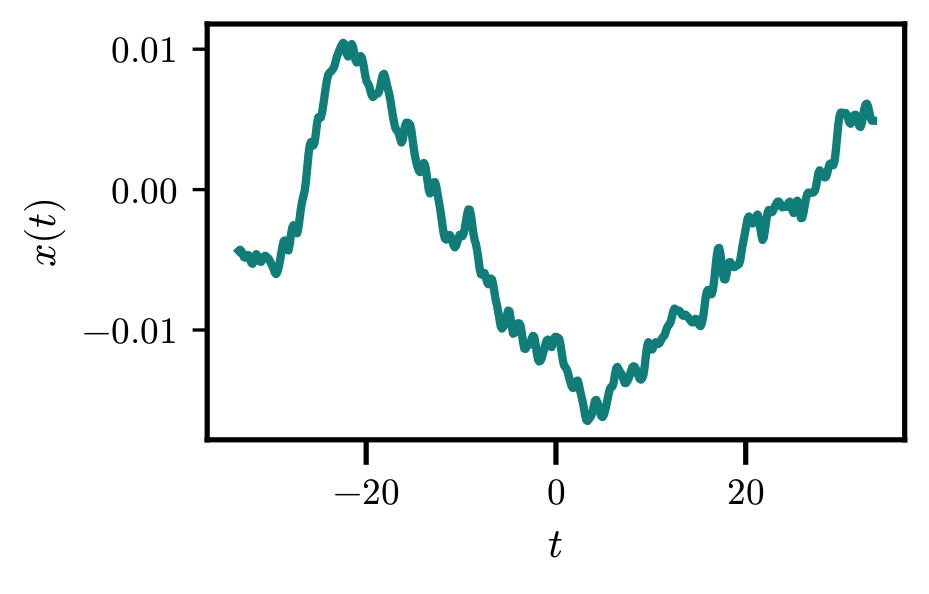

iter 0: elbo = -538.38 (+nan improvement)
iter 1: elbo = 836.37 (+2.55351519 improvement)
iter 2: elbo = 1485.37 (+0.77595743 improvement)
iter 3: elbo = 1763.55 (+0.18728654 improvement)
iter 4: elbo = 1881.01 (+0.06660013 improvement)
iter 5: elbo = 2243.45 (+0.19268468 improvement)
iter 6: elbo = 2674.10 (+0.19195751 improvement)
iter 7: elbo = 2932.67 (+0.09669660 improvement)
iter 8: elbo = 3077.00 (+0.04921472 improvement)
iter 9: elbo = 3162.49 (+0.02778244 improvement)
iter 10: elbo = 3228.48 (+0.02086694 improvement)
iter 11: elbo = 3289.58 (+0.01892662 improvement)
iter 12: elbo = 3348.72 (+0.01797730 improvement)
iter 13: elbo = 3412.04 (+0.01890945 improvement)
iter 14: elbo = 3487.14 (+0.02201031 improvement)
iter 15: elbo = 3575.12 (+0.02522935 improvement)
iter 16: elbo = 3668.95 (+0.02624409 improvement)
iter 17: elbo = 3757.22 (+0.02405918 improvement)
iter 18: elbo = 3828.57 (+0.01899072 improvement)
iter 19: elbo = 3875.89 (+0.01235759 improvement)
iter 20: elbo = 39

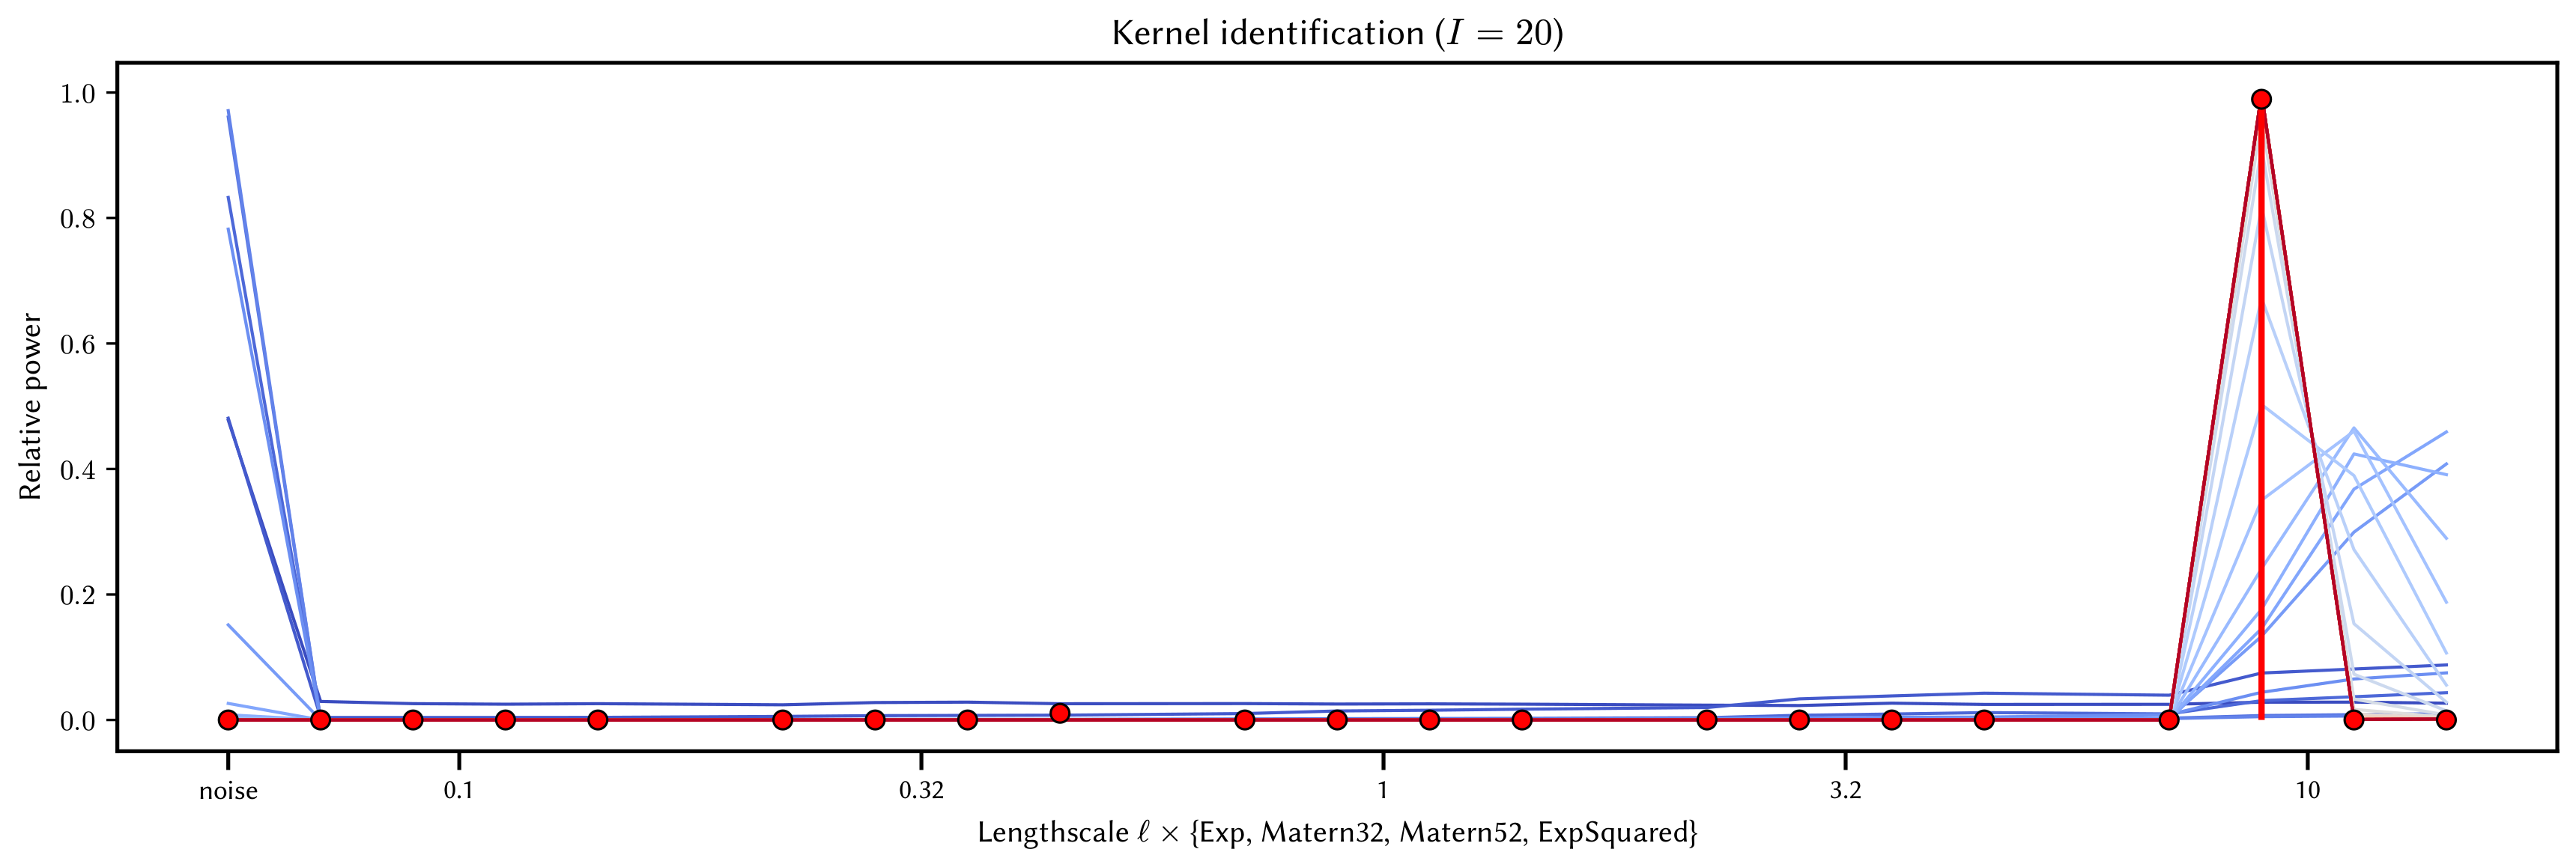


	RUN GROUND TRUTH

nu_w        = 0.0299
nu_e        = 0.0000
sum(theta)  = 0.0000
pitchedness = 1.0000
I_eff       = 1.0000
l_eff       = 11.5470


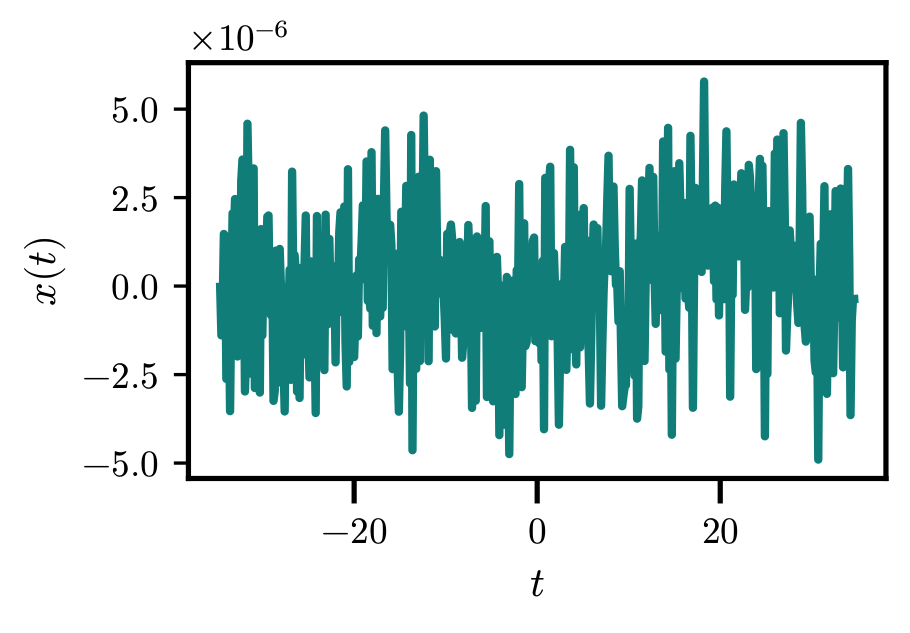

iter 0: elbo = -537.84 (+nan improvement)
iter 1: elbo = 1443.14 (+3.68324158 improvement)
iter 2: elbo = 3352.30 (+1.32291836 improvement)
iter 3: elbo = 4860.64 (+0.44994050 improvement)
iter 4: elbo = 5659.75 (+0.16440549 improvement)
iter 5: elbo = 6013.23 (+0.06245577 improvement)
iter 6: elbo = 6147.52 (+0.02233130 improvement)
iter 7: elbo = 6192.23 (+0.00727357 improvement)
iter 8: elbo = 6205.62 (+0.00216255 improvement)
iter 9: elbo = 6209.88 (+0.00068508 improvement)
iter 10: elbo = 6210.96 (+0.00017506 improvement)
iter 11: elbo = 6211.19 (+0.00003708 improvement)
iter 12: elbo = 6211.25 (+0.00000882 improvement)
iter 13: elbo = 6211.26 (+0.00000221 improvement)
iter 14: elbo = 6211.26 (+0.00000055 improvement)
Score(DKL) of inferred power distribution (lower is better, 1.0 is perfect):  2.422142012741079
Score(Wasserstein) between true and inferred power distribution (lower is better, 0.0 is perfect):  1.1614905082913185


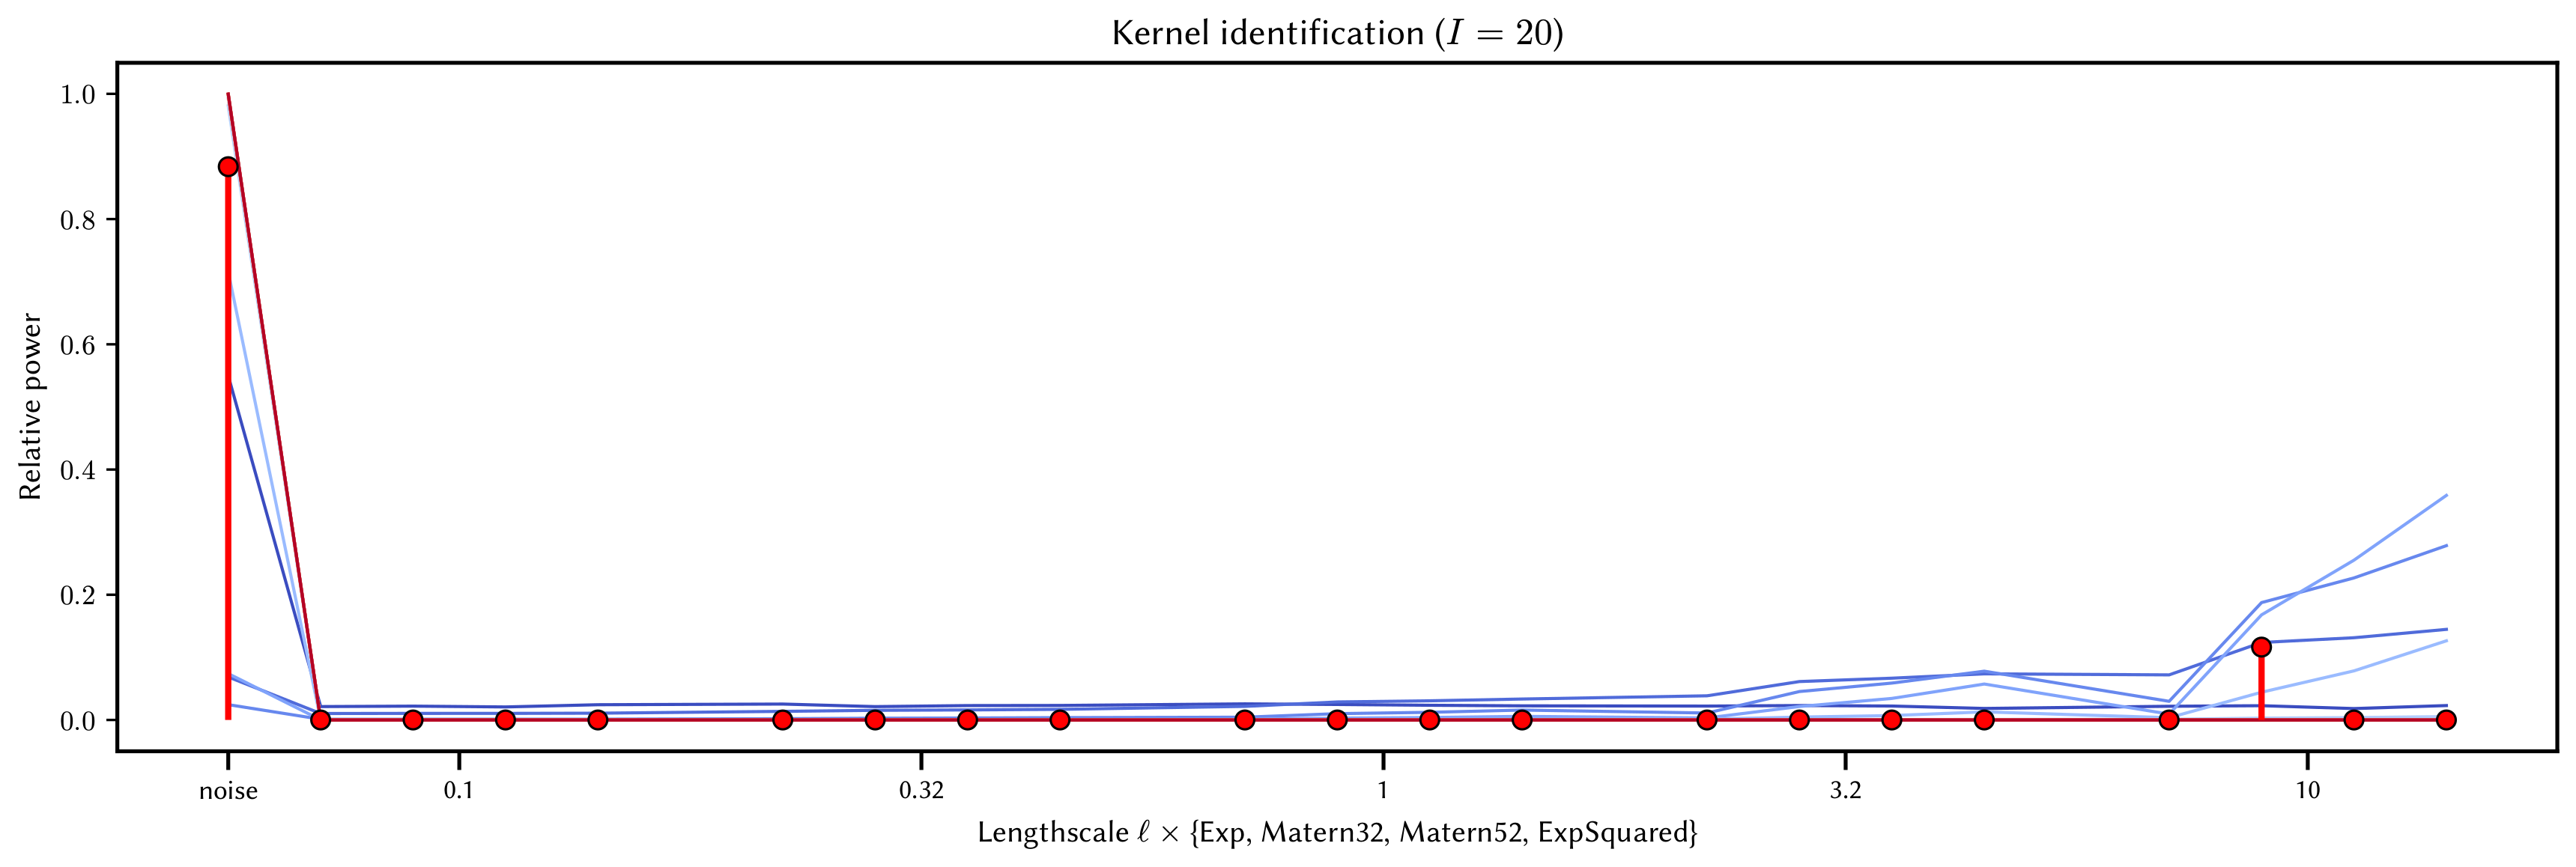

In [9]:
results = [do_run(key, h) for key in jax.random.split(master_key, N_runs)]